# Noise Model Simulation: FakeGeneva

Running ideal simulation...

Measurement Probabilities (Ideal):
  State |000000001>: 0.0550
  State |000000100>: 0.2630
  State |000010000>: 0.3680
  State |001000000>: 0.2360
  State |100000000>: 0.0780

Running noisy simulation...

Measurement Probabilities (Noisy):
  State |000000000>: 0.1530
  State |000000001>: 0.0410
  State |000000100>: 0.1310
  State |000000101>: 0.0240
  State |000010000>: 0.1680
  State |000010001>: 0.0200
  State |000010100>: 0.0570
  State |000010101>: 0.0100
  State |001000000>: 0.1220
  State |001000001>: 0.0100
  State |001000100>: 0.0310
  State |001000101>: 0.0090
  State |001010000>: 0.0430
  State |001010001>: 0.0070
  State |001010100>: 0.0190
  State |001010101>: 0.0050
  State |100000000>: 0.0330
  State |100000001>: 0.0050
  State |100000100>: 0.0200
  State |100000101>: 0.0020
  State |100010000>: 0.0190
  State |100010001>: 0.0010
  State |100010100>: 0.0070
  State |100010101>: 0.0010
  State |101000000>: 0.0310
  State |101000001>: 0.0030
  S

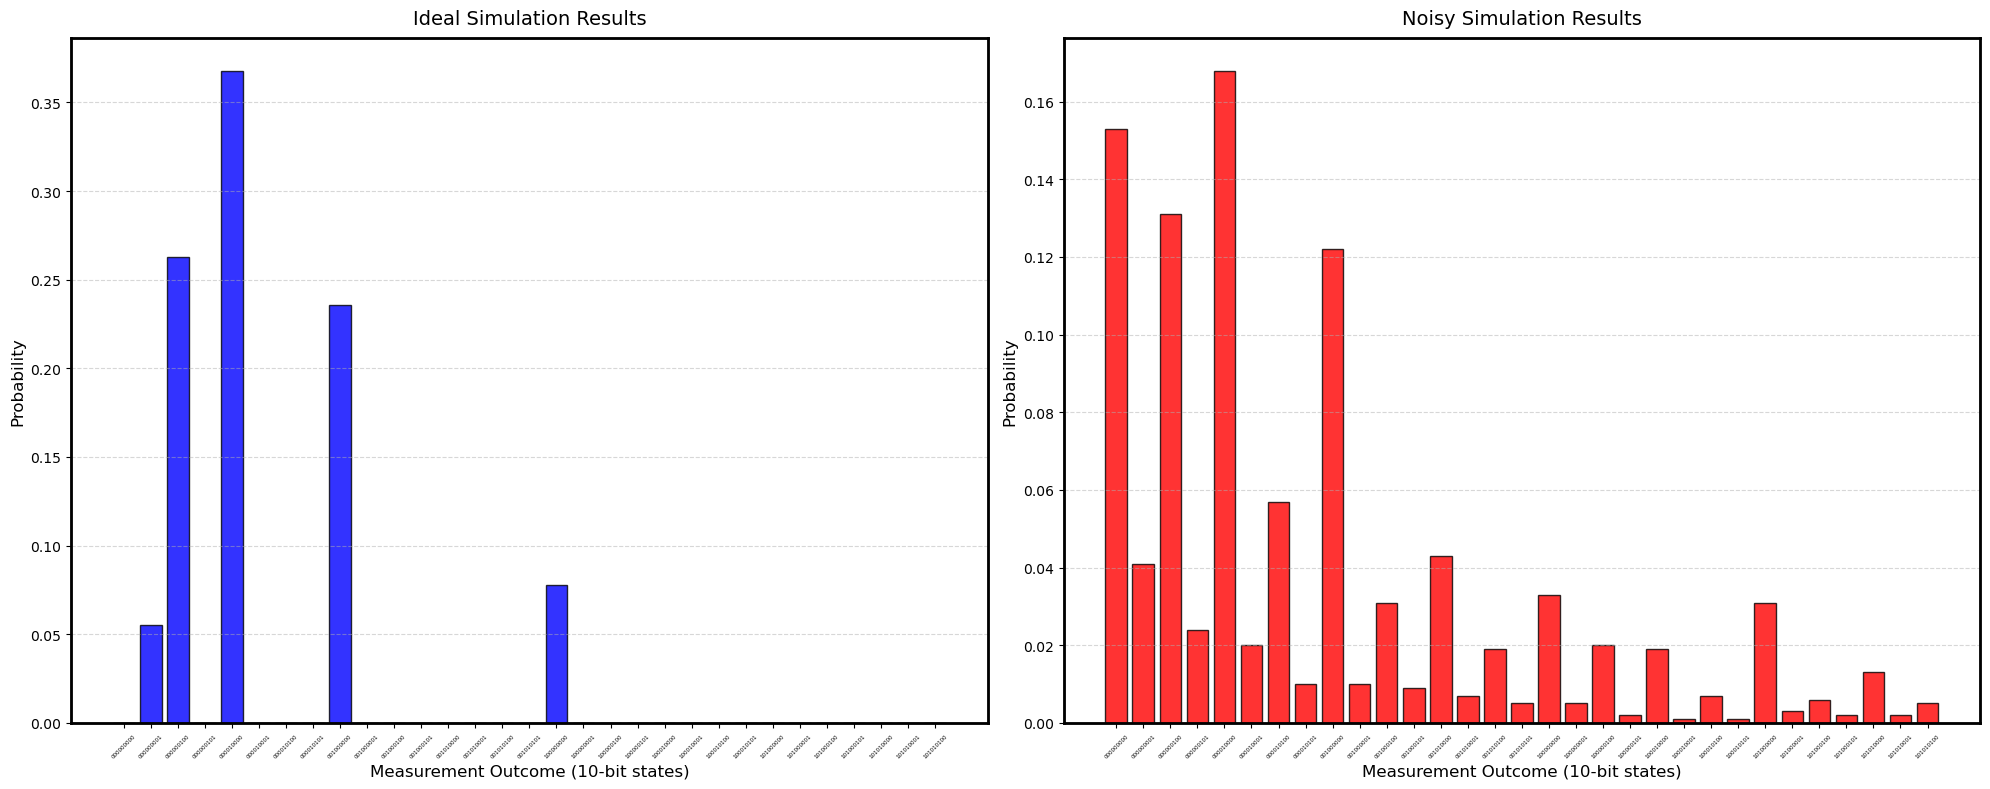

In [16]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeGeneva # Using FakeWashingtonV2 as our noisy backend
import matplotlib.pyplot as plt
import numpy as np


def build_normal_distribution_circuit(num_qubits: int) -> QuantumCircuit:
    """
    Constructs the quantum normal distribution circuit using H and CSWAP gates.
    
    Parameters:
        num_qubits (int): Number of qubits used for encoding the distribution.

    Returns:
        QuantumCircuit: The constructed quantum circuit.
    """
    q = QuantumRegister(num_qubits, 'q')
    c = ClassicalRegister(num_qubits-1, 'c')
    qc = QuantumCircuit(q, c)

    # Initialize the central qubit (impulse at the center)
    qc.x(q[num_qubits // 2])

    # Gate operations creating the effect of gaussian probability spread
    for block in range(1, num_qubits // 2):
        qc.reset(q[0])        # Ancilla reset
        qc.h(q[0])            # Hadamard for superposition

        for op in range(1, 2 * block + 1):
            left = q[num_qubits // 2 - block + op - 1]
            right = q[num_qubits // 2 - block + op]

            qc.cswap(q[0], left, right)

            if op != 2 * block:
                qc.cx(right, q[0])

    # Add measurements to every other qubit (odd index)
    for i in range(1, num_qubits, 2):
        qc.measure(q[i], c[i-1])

    return qc


def run_noisy_simulation(qc: QuantumCircuit, shots: int = 1000):
    """
    Runs the quantum simulation with a noise model from a fake backend and returns the result counts.
    """
    # Load the fake backend
    fake_backend = FakeGeneva()
    
    # Create noisy simulator from the fake backend
    noisy_simulator = AerSimulator.from_backend(fake_backend)
    
    # Transpile the circuit for the noisy backend
    compiled = transpile(qc, noisy_simulator)
    
    # Run the noisy simulation
    job = noisy_simulator.run(compiled, shots=shots)
    result = job.result()
    return result.get_counts(qc)


def run_ideal_simulation(qc: QuantumCircuit, shots: int = 1000):
    """
    Runs the ideal quantum simulation (without noise) and returns the result counts.
    """
    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=shots)
    result = job.result()
    return result.get_counts(qc)


def calculate_probabilities(counts: dict) -> dict:
    """
    Converts raw measurement counts into probabilities.
    """
    total_shots = sum(counts.values())
    return {state: count / total_shots for state, count in counts.items()}


def plot_comparison(ideal_probs: dict, noisy_probs: dict, num_qubits: int):
    """
    Plots a comparison between ideal and noisy probability distributions using subplots
    with bordered boxes for better visual separation.
    """
    if not ideal_probs or not noisy_probs:
        print("No measurement outcomes to plot.")
        return

    # Get all possible states and sort them
    all_states = sorted(set(ideal_probs.keys()).union(set(noisy_probs.keys())), 
                    key=lambda x: int(x, 2))
    
    # Prepare data for plotting
    ideal_values = [ideal_probs.get(state, 0) for state in all_states]
    noisy_values = [noisy_probs.get(state, 0) for state in all_states]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Add boxes around each subplot
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_linewidth(2)  # Make borders thicker
            spine.set_color('black')  # Set border color
    
    # Plot ideal simulation
    ax1.bar(all_states, ideal_values, color='blue', alpha=0.8, edgecolor='black')
    ax1.set_xlabel(f"Measurement Outcome ({num_qubits}-bit states)", fontsize=12)
    ax1.set_ylabel("Probability", fontsize=12)
    ax1.set_title("Ideal Simulation Results", fontsize=14, pad=10)
    ax1.tick_params(axis='x', rotation=45, labelsize=4)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Add a background rectangle for the plot area
    ax1.patch.set_edgecolor('black')  
    ax1.patch.set_linewidth(1)
    
    # Plot noisy simulation
    ax2.bar(all_states, noisy_values, color='red', alpha=0.8, edgecolor='black')
    ax2.set_xlabel(f"Measurement Outcome ({num_qubits}-bit states)", fontsize=12)
    ax2.set_ylabel("Probability", fontsize=12)
    ax2.set_title("Noisy Simulation Results", fontsize=14, pad=10)
    ax2.tick_params(axis='x', rotation=45, labelsize=4)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Add a background rectangle for the plot area
    ax2.patch.set_edgecolor('black')  
    ax2.patch.set_linewidth(1)
    
    # Adjust layout with more padding
    plt.tight_layout()
    plt.show()


def main(num_qubits=14, shots=10000):
    """
    Main execution function to simulate and plot both ideal and noisy versions.
    """
    qc = build_normal_distribution_circuit(num_qubits)
    
    print("Running ideal simulation...")
    ideal_counts = run_ideal_simulation(qc, shots)
    ideal_probs = calculate_probabilities(ideal_counts)
    
    print("\nMeasurement Probabilities (Ideal):")
    for state, prob in sorted(ideal_probs.items()):
        print(f"  State |{state}>: {prob:.4f}")

    print("\nRunning noisy simulation...")
    noisy_counts = run_noisy_simulation(qc, shots)
    noisy_probs = calculate_probabilities(noisy_counts)

    print("\nMeasurement Probabilities (Noisy):")
    for state, prob in sorted(noisy_probs.items()):
        print(f"  State |{state}>: {prob:.4f}")

    plot_comparison(ideal_probs, noisy_probs, num_qubits)


if __name__ == "__main__":
    main(num_qubits=10, shots=1000)

# Optimization & Stochastic Uncertainty Analysis: Fidelity, Similarity


==================== Configuration:  ====================
Parameters: qubits=10, shots=1000, tolerance=0.5, strict=True
=== Original Circuit ===
Original        Depth:   45, Size:   50, CX:   16

=== Stage 1: Custom Pre-optimization ===
TV Distance: 0.0310, KL Divergence: 0.0029
Pre-opt         Depth:   45, Size:   50, CX:   16
✓ Distribution equivalence verified

=== Stage 2: Standard Transpilation (Level 1) ===
TV Distance: 0.0175, KL Divergence: 0.0008
Level 1         Depth:  541, Size:  624, CX:  362
✓ Distribution equivalence verified

=== Stage 2: Standard Transpilation (Level 2) ===
TV Distance: 0.0335, KL Divergence: 0.0027
Level 2         Depth:  586, Size:  888, CX:  298
✓ Distribution equivalence verified

=== Stage 2: Standard Transpilation (Level 3) ===


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


TV Distance: 0.0245, KL Divergence: 0.0020
Level 3         Depth:  586, Size:  888, CX:  298
✓ Distribution equivalence verified

=== Stage 3: AI Transpilation ===

Mode: keep


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


TV Distance: 0.6195, KL Divergence: 6.9139
✗ AI transpilation rejected due to distribution changes

Mode: improve


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


TV Distance: 0.6185, KL Divergence: 6.8958
✗ AI transpilation rejected due to distribution changes

Mode: optimize


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


TV Distance: 0.6225, KL Divergence: 6.9565
✗ AI transpilation rejected due to distribution changes

=== Stage 4: Hybrid Optimization ===
TV Distance: 0.0290, KL Divergence: 0.0024
Hybrid          Depth:  586, Size:  887, CX:  298
✓ Distribution equivalence verified

=== Optimization Summary ===
Total valid circuits: 6
Strict mode: ON

--- Evaluating pre_opt ---
Fidelity: 0.7797

--- Evaluating standard_L1 ---
Fidelity: 0.5051

--- Evaluating standard_L2 ---
Fidelity: 0.4603

--- Evaluating standard_L3 ---
Fidelity: 0.5068

--- Evaluating hybrid ---
Fidelity: 0.4705

=== Circuit Comparison ===
Name		Fidelity	Depth	CX	Score
--------------------------------------------------
pre_opt        	0.7797		45	16	0.2497
standard_L1    	0.5051		541	362	-6.7149
standard_L2    	0.4603		586	298	-6.8897
standard_L3    	0.5068		586	298	-6.8432
hybrid         	0.4705		586	298	-6.8795

Optimal circuit: pre_opt (Score: 0.2497)

=== Verification Summary ===
pre_opt: ✓ Similarity = 0.9648
standard_L1: ✓ Simi

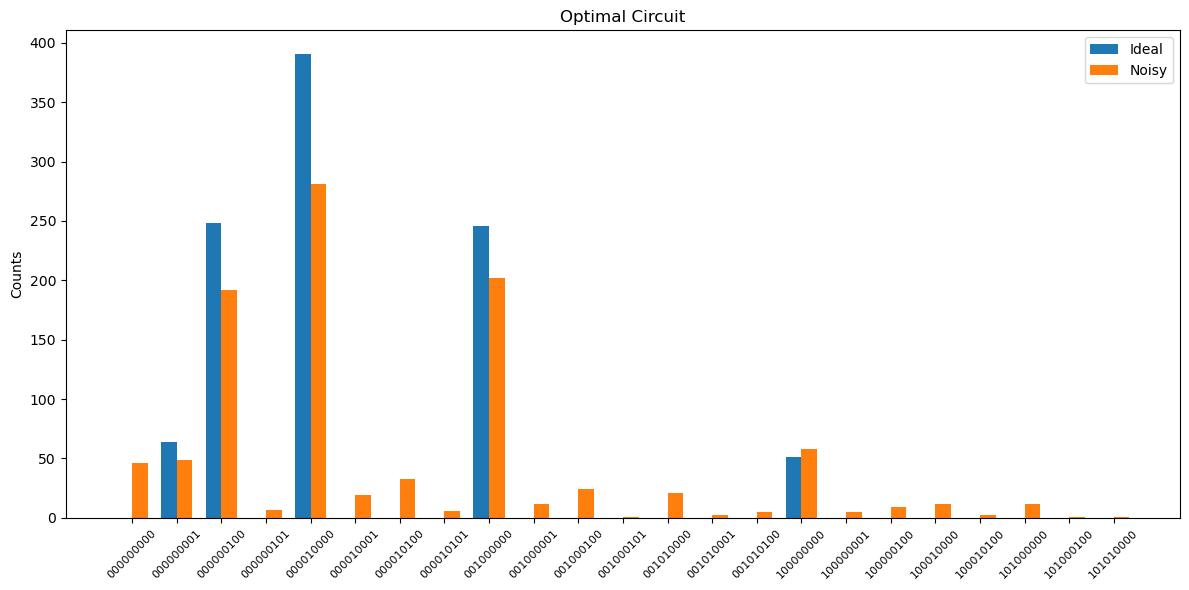

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeGeneva
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes import Optimize1qGatesDecomposition, InverseCancellation, CommutativeCancellation
from qiskit.transpiler import PassManager
from qiskit.circuit.library import HGate, XGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, Optional, List
from scipy.stats import entropy
import warnings

# Optional AI transpiler import
try:
    from qiskit_ibm_transpiler import generate_ai_pass_manager
    AI_TRANSPILER_AVAILABLE = True
except ImportError:
    AI_TRANSPILER_AVAILABLE = False
    print("Note: qiskit_ibm_transpiler not available. AI optimization will be skipped.")

# ==================================================================
# Circuit Construction Module
# ==================================================================

def build_normal_distribution_circuit(num_qubits: int) -> QuantumCircuit:
    """Build a quantum circuit for normal distribution generation."""
    q = QuantumRegister(num_qubits, 'q')
    c = ClassicalRegister(num_qubits-1, 'c')
    qc = QuantumCircuit(q, c)
    
    # Initialize the center qubit
    qc.x(q[num_qubits // 2])
    
    # Build the distribution pattern
    for block in range(1, num_qubits // 2):
        qc.reset(q[0])
        qc.h(q[0])
        for op in range(1, 2 * block + 1):
            left = q[num_qubits // 2 - block + op - 1]
            right = q[num_qubits // 2 - block + op]
            qc.cswap(q[0], left, right)
            if op != 2 * block:
                qc.cx(right, q[0])
    
    # Measure odd-indexed qubits
    for i in range(1, num_qubits, 2):
        qc.measure(q[i], c[i-1])
    
    return qc

# ==================================================================
# Circuit Analysis Module
# ==================================================================

def get_circuit_metrics(circuit: QuantumCircuit) -> Tuple[int, int, int, int]:
    """Extract key metrics from a quantum circuit."""
    depth = circuit.depth()
    size = circuit.size()
    counts = circuit.count_ops()
    cx_count = counts.get('cx', 0) + counts.get('CX', 0)
    two_qubit_count = sum(counts.get(gate, 0) for gate in ['cx', 'CX', 'cz', 'CZ', 'swap', 'cswap'])
    return depth, size, cx_count, two_qubit_count

def print_circuit_metrics(name: str, circuit: QuantumCircuit):
    """Print formatted metrics for a circuit."""
    depth, size, cx_count, _ = get_circuit_metrics(circuit)
    print(f"{name:15} Depth: {depth:4}, Size: {size:4}, CX: {cx_count:4}")

# ==================================================================
# Optimization Passes Module
# ==================================================================

def create_custom_optimization_pass() -> PassManager:
    """Create a custom optimization pass manager for pre-processing."""
    pm = PassManager()
    pm.append(Optimize1qGatesDecomposition())
    pm.append(InverseCancellation([HGate(), XGate()]))
    pm.append(CommutativeCancellation())
    return pm

def create_standard_transpilation_passes(backend, opt_level: int) -> PassManager:
    """Create standard transpilation passes for a given optimization level."""
    return transpile(PassManager(), backend=backend, optimization_level=opt_level)

def create_ai_transpilation_passes(backend, mode: str) -> Optional[PassManager]:
    """Create AI-based transpilation passes if available."""
    if not AI_TRANSPILER_AVAILABLE:
        return None
    
    try:
        coupling_map_obj = CouplingMap(backend.configuration().coupling_map)
        return generate_ai_pass_manager(
            coupling_map=coupling_map_obj,
            ai_optimization_level=3,
            optimization_level=3,
            ai_layout_mode=mode,
        )
    except Exception as e:
        print(f"AI transpilation setup failed: {e}")
        return None

# ==================================================================
# Circuit Verification Module
# ==================================================================

def compute_distribution_similarity(counts1: dict, counts2: dict, shots: int, 
                                  tolerance: float = 0.05) -> Tuple[float, bool]:
    """
    Compare two probability distributions using multiple metrics.
    Returns (similarity_score, is_equivalent)
    """
    all_keys = set(counts1.keys()).union(set(counts2.keys()))
    
    # Convert to probability distributions
    prob1 = np.array([counts1.get(k, 0) / shots for k in sorted(all_keys)])
    prob2 = np.array([counts2.get(k, 0) / shots for k in sorted(all_keys)])
    
    # 1. Fidelity (quantum fidelity for probability distributions)
    fidelity = np.sum(np.sqrt(prob1 * prob2))**2
    
    # 2. Total Variation Distance
    tv_distance = 0.5 * np.sum(np.abs(prob1 - prob2))
    
    # 3. KL Divergence (symmetric)
    epsilon = 1e-10
    prob1_smooth = prob1 + epsilon
    prob2_smooth = prob2 + epsilon
    prob1_smooth /= np.sum(prob1_smooth)
    prob2_smooth /= np.sum(prob2_smooth)
    
    kl_div = 0.5 * (entropy(prob1_smooth, prob2_smooth) + entropy(prob2_smooth, prob1_smooth))
    
    # Composite similarity score (higher is better)
    similarity = fidelity * (1 - tv_distance) / (1 + kl_div)
    
    # Check if distributions are equivalent within tolerance
    is_equivalent = (
        fidelity >= (1 - tolerance) and
        tv_distance <= tolerance and
        kl_div <= tolerance
    )
    # Print metrics
    print(f"TV Distance: {tv_distance:.4f}, KL Divergence: {kl_div:.4f}")
    return similarity, is_equivalent

def verify_circuit_equivalence(original_circuit: QuantumCircuit, 
                             optimized_circuit: QuantumCircuit,
                             shots: int = 2000,
                             tolerance: float = 0.05) -> Tuple[bool, Dict]:
    """
    Verify that two circuits produce equivalent probability distributions.
    """
    simulator = AerSimulator()
    
    try:
        orig_compiled = transpile(original_circuit, simulator)
        opt_compiled = transpile(optimized_circuit, simulator)
        
        orig_job = simulator.run(orig_compiled, shots=shots)
        opt_job = simulator.run(opt_compiled, shots=shots)
        
        orig_counts = orig_job.result().get_counts()
        opt_counts = opt_job.result().get_counts()
        
        similarity, is_equivalent = compute_distribution_similarity(
            orig_counts, opt_counts, shots, tolerance
        )
        
        return is_equivalent, {
            'is_equivalent': is_equivalent,
            'similarity_score': similarity,
            'original_counts': orig_counts,
            'optimized_counts': opt_counts,
            'tolerance_used': tolerance
        }
        
    except Exception as e:
        print(f"Verification failed: {e}")
        return False, {'error': str(e)}
    
# ==================================================================
# Evaluation and Analysis Module
# ==================================================================

def evaluate_circuit(circuit: QuantumCircuit, 
                    noise_model: NoiseModel,
                    shots: int = 1000) -> Dict:
    """Evaluate a single circuit with both ideal and noisy simulations."""
    sim_ideal = AerSimulator()
    sim_noisy = AerSimulator(noise_model=noise_model)
    
    try:
        ideal_compiled = transpile(circuit, sim_ideal)
        ideal_job = sim_ideal.run(ideal_compiled, shots=shots)
        ideal_counts = ideal_job.result().get_counts(circuit)
        
        noisy_compiled = transpile(circuit, sim_noisy)
        noisy_job = sim_noisy.run(noisy_compiled, shots=shots)
        noisy_counts = noisy_job.result().get_counts(circuit)
        
        # Calculate fidelity
        all_keys = set(ideal_counts.keys()).union(noisy_counts.keys())
        ideal_probs = np.array([ideal_counts.get(k, 0)/shots for k in all_keys])
        noisy_probs = np.array([noisy_counts.get(k, 0)/shots for k in all_keys])
        fidelity = np.sum(np.sqrt(ideal_probs * noisy_probs))**2
        
        return {
            'ideal_counts': ideal_counts,
            'noisy_counts': noisy_counts,
            'fidelity': fidelity
        }
        
    except Exception as e:
        print(f"Simulation failed: {e}")
        return {'error': str(e)}

def evaluate_all_circuits(circuits_dict: Dict, 
                        noise_model: NoiseModel,
                        shots: int = 1000) -> Dict:
    """Evaluate all circuits in a dictionary."""
    evaluation_results = {}
    
    for name, result in circuits_dict.items():
        if 'circuit' not in result:
            continue
        
        if name == "original":  # Skip fidelity for original
            continue
            
        print(f"\n--- Evaluating {name} ---")
        eval_result = evaluate_circuit(result['circuit'], noise_model, shots)
        
        if 'fidelity' in eval_result:
            evaluation_results[name] = {
                **result,
                **eval_result
            }
            print(f"Fidelity: {eval_result['fidelity']:.4f}")
    
    return evaluation_results

def find_optimal_circuit(evaluation_results: Dict) -> Tuple[str, Dict]:
    """Find the optimal circuit based on a composite score."""
    best_name = None
    best_score = -1
    
    print("\n=== Circuit Comparison ===")
    print("Name\t\tFidelity\tDepth\tCX\tScore")
    print("-" * 50)
    
    for name, result in evaluation_results.items():
        fidelity = result.get('fidelity', 0)
        depth = result.get('depth', 0)
        cx_count = result.get('cx_count', 0)
        
        # Composite score: prioritize fidelity, then minimize depth and CX count
        score = fidelity - 0.01 * depth - 0.005 * cx_count
        
        print(f"{name:15}\t{fidelity:.4f}\t\t{depth}\t{cx_count}\t{score:.4f}")
        
        if score > best_score:
            best_score = score
            best_name = name
    
    if best_name:
        print(f"\nOptimal circuit: {best_name} (Score: {best_score:.4f})")
        return best_name, evaluation_results[best_name]
    else:
        print("\nNo optimal circuit found!")
        return None, {}

def plot_comparison(evaluation_results: Dict, optimal_name: str):
    """Plot comparison of ideal vs noisy results for the optimal circuit."""
    if optimal_name not in evaluation_results:
        return
        
    result = evaluation_results[optimal_name]
    ideal = result['ideal_counts']
    noisy = result['noisy_counts']
    
    # Get all possible keys
    all_keys = set(ideal.keys()).union(set(noisy.keys()))
    
    # Prepare data for plotting
    labels = sorted(all_keys)
    ideal_vals = [ideal.get(k, 0) for k in labels]
    noisy_vals = [noisy.get(k, 0) for k in labels]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, ideal_vals, width, label='Ideal')
    rects2 = ax.bar(x + width/2, noisy_vals, width, label='Noisy')
    
    ax.set_ylabel('Counts')
    ax.set_title(f'Optimal Circuit')
    ax.set_xticks(x)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# ==================================================================
# Optimization Stages Module
# ==================================================================

def run_pre_optimization(original_circuit: QuantumCircuit, 
                        strict_mode: bool,
                        verification_shots: int,
                        tolerance: float) -> Tuple[QuantumCircuit, Dict]:
    """Run custom pre-optimization stage."""
    print("\n=== Stage 1: Custom Pre-optimization ===")
    try:
        custom_pm = create_custom_optimization_pass()
        qc_pre_opt = custom_pm.run(original_circuit.copy())
        
        is_valid, verification_result = verify_circuit_equivalence(
            original_circuit, qc_pre_opt, verification_shots, tolerance
        )
        
        if is_valid or not strict_mode:
            print_circuit_metrics("Pre-opt", qc_pre_opt)
            if is_valid:
                print("✓ Distribution equivalence verified")
            else:
                print(f"⚠ Distribution equivalence failed (similarity: {verification_result.get('similarity_score', 0):.4f}")
            return qc_pre_opt, verification_result
        else:
            print("✗ Pre-optimization rejected due to distribution changes")
            return original_circuit, verification_result
            
    except Exception as e:
        print(f"Pre-optimization failed: {e}")
        return original_circuit, {'error': str(e)}

def run_standard_transpilation(pre_opt_circuit: QuantumCircuit, 
                             original_circuit: QuantumCircuit,
                             backend,
                             strict_mode: bool,
                             verification_shots: int,
                             tolerance: float) -> Dict:
    """Run standard transpilation optimization stages."""
    valid_results = {}
    
    for opt_level in [1, 2, 3]:
        print(f"\n=== Stage 2: Standard Transpilation (Level {opt_level}) ===")
        try:
            qc_transpiled = transpile(
                pre_opt_circuit.copy(),
                backend=backend,
                optimization_level=opt_level,
                seed_transpiler=42
            )
            
            is_valid, verification_result = verify_circuit_equivalence(
                original_circuit, qc_transpiled, verification_shots, tolerance
            )
            
            if is_valid or not strict_mode:
                print_circuit_metrics(f"Level {opt_level}", qc_transpiled)
                if is_valid:
                    print("✓ Distribution equivalence verified")
                else:
                    print(f"⚠ Distribution equivalence failed (similarity: {verification_result.get('similarity_score', 0):.4f}")
                
                depth, size, cx_count, _ = get_circuit_metrics(qc_transpiled)
                valid_results[f'standard_L{opt_level}'] = {
                    'circuit': qc_transpiled, 
                    'depth': depth, 
                    'size': size, 
                    'cx_count': cx_count,
                    'verification': verification_result
                }
            else:
                print("✗ Standard transpilation rejected due to distribution changes")
                
        except Exception as e:
            print(f"Standard transpilation level {opt_level} failed: {e}")
    
    return valid_results

def run_ai_transpilation(pre_opt_circuit: QuantumCircuit,
                        original_circuit: QuantumCircuit,
                        backend,
                        strict_mode: bool,
                        verification_shots: int,
                        tolerance: float) -> Dict:
    """Run AI-enhanced transpilation if available."""
    valid_results = {}
    
    if not AI_TRANSPILER_AVAILABLE:
        print("\n=== Stage 3: AI Transpilation (Skipped) ===")
        print("AI transpilation not available")
        return valid_results
    
    print("\n=== Stage 3: AI Transpilation ===")
    ai_modes = ['keep', 'improve', 'optimize']
    
    for mode in ai_modes:
        print(f"\nMode: {mode}")
        try:
            ai_pass_manager = create_ai_transpilation_passes(backend, mode)
            if ai_pass_manager is None:
                continue
                
            qc_ai_opt = ai_pass_manager.run(pre_opt_circuit.copy())
            
            is_valid, verification_result = verify_circuit_equivalence(
                original_circuit, qc_ai_opt, verification_shots, tolerance
            )
            
            if is_valid or not strict_mode:
                print_circuit_metrics(f"AI {mode}", qc_ai_opt)
                if is_valid:
                    print("✓ Distribution equivalence verified")
                else:
                    print(f"⚠ Distribution equivalence failed (similarity: {verification_result.get('similarity_score', 0):.4f}")
                
                depth, size, cx_count, _ = get_circuit_metrics(qc_ai_opt)
                valid_results[f'ai_{mode}'] = {
                    'circuit': qc_ai_opt, 
                    'depth': depth, 
                    'size': size, 
                    'cx_count': cx_count,
                    'verification': verification_result
                }
            else:
                print("✗ AI transpilation rejected due to distribution changes")
                
        except Exception as e:
            print(f"AI transpilation with mode '{mode}' failed: {e}")
    
    return valid_results

def run_hybrid_optimization(valid_optimizations: Dict,
                          original_circuit: QuantumCircuit,
                          backend,
                          strict_mode: bool,
                          verification_shots: int,
                          tolerance: float) -> Dict:
    """Run hybrid optimization combining best results."""
    print("\n=== Stage 4: Hybrid Optimization ===")
    
    if not valid_optimizations:
        print("No valid circuits available for hybrid optimization")
        return {}
    
    # Find best circuit for hybrid optimization
    best_circuit = None
    best_score = float('inf')
    
    for name, result in valid_optimizations.items():
        score = result['depth'] + result['cx_count']
        if score < best_score:
            best_score = score
            best_circuit = result['circuit']
    
    if best_circuit is None:
        return {}
    
    try:
        qc_hybrid = transpile(
            best_circuit.copy(),
            backend=backend,
            optimization_level=2,
            seed_transpiler=42
        )
        
        is_valid, verification_result = verify_circuit_equivalence(
            original_circuit, qc_hybrid, verification_shots, tolerance
        )
        
        if is_valid or not strict_mode:
            print_circuit_metrics("Hybrid", qc_hybrid)
            if is_valid:
                print("✓ Distribution equivalence verified")
            else:
                print(f"⚠ Distribution equivalence failed (similarity: {verification_result.get('similarity_score', 0):.4f}")
            
            depth, size, cx_count, _ = get_circuit_metrics(qc_hybrid)
            return {
                'hybrid': {
                    'circuit': qc_hybrid, 
                    'depth': depth, 
                    'size': size, 
                    'cx_count': cx_count,
                    'verification': verification_result
                }
            }
        else:
            print("✗ Hybrid optimization rejected due to distribution changes")
            return {}
            
    except Exception as e:
        print(f"Hybrid optimization failed: {e}")
        return {}

# ==================================================================
# Main Optimization Function
# ==================================================================

def constrained_multi_stage_optimization(
    qc: QuantumCircuit, 
    backend,
    verification_shots: int = 2000,
    tolerance: float = 0.05,
    execution_shots: int = 1000,
    strict_mode: bool = True
) -> Tuple[Dict, NoiseModel, Dict]:
    """
    Multi-stage optimization with distributional equivalence constraints.
    
    Returns:
        (valid_circuits_dict, noise_model, verification_log)
    """
    # Initialize results
    results = {}
    verification_log = {}
    noise_model = NoiseModel.from_backend(backend)
    
    # Store original circuit metrics
    depth, size, cx_count, _ = get_circuit_metrics(qc)
    results['original'] = {
        'circuit': qc, 
        'depth': depth, 
        'size': size, 
        'cx_count': cx_count
    }
    
    print("=== Original Circuit ===")
    print_circuit_metrics("Original", qc)
    
    # Stage 1: Custom pre-optimization
    qc_pre_opt, pre_opt_log = run_pre_optimization(
        qc, strict_mode, verification_shots, tolerance
    )
    verification_log['pre_opt'] = pre_opt_log
    
    if 'error' not in pre_opt_log and (pre_opt_log.get('is_equivalent', False) or not strict_mode):
        depth, size, cx_count, _ = get_circuit_metrics(qc_pre_opt)
        results['pre_opt'] = {
            'circuit': qc_pre_opt, 
            'depth': depth, 
            'size': size, 
            'cx_count': cx_count
        }
    
    # Stage 2: Standard transpilation
    standard_results = run_standard_transpilation(
        qc_pre_opt, qc, backend, strict_mode, verification_shots, tolerance
    )
    results.update(standard_results)
    verification_log.update({k: v['verification'] for k, v in standard_results.items()})
    
    # Stage 3: AI transpilation
    ai_results = run_ai_transpilation(
        qc_pre_opt, qc, backend, strict_mode, verification_shots, tolerance
    )
    results.update(ai_results)
    verification_log.update({k: v['verification'] for k, v in ai_results.items()})
    
    # Stage 4: Hybrid optimization
    hybrid_results = run_hybrid_optimization(
        {**standard_results, **ai_results},
        qc,
        backend,
        strict_mode,
        verification_shots,
        tolerance
    )
    results.update(hybrid_results)
    verification_log.update({k: v['verification'] for k, v in hybrid_results.items()})
    
    # Print summary
    print(f"\n=== Optimization Summary ===")
    print(f"Total valid circuits: {len(results)}")
    print(f"Strict mode: {'ON' if strict_mode else 'OFF'}")
    
    return results, noise_model, verification_log

# ==================================================================
# Main Execution Functions
# ==================================================================

def run_single_configuration(
    num_qubits: int = 6,
    verification_shots: int = 2000,
    execution_shots: int = 1000,
    tolerance: float = 0.05,
    strict_mode: bool = True,
    config_name: str = ""
):
    """Run optimization with a single configuration."""
    print(f"\n{'='*20} Configuration: {config_name} {'='*20}")
    print(f"Parameters: qubits={num_qubits}, shots={execution_shots}, "
          f"tolerance={tolerance}, strict={strict_mode}")
    
    backend = FakeGeneva()
    qc = build_normal_distribution_circuit(num_qubits)
    
    valid_circuits, noise_model, verification_log = constrained_multi_stage_optimization(
        qc, backend, verification_shots, tolerance, execution_shots, strict_mode
    )
    
    if valid_circuits:
        evaluation_results = evaluate_all_circuits(valid_circuits, noise_model, execution_shots)
        
        if evaluation_results:
            optimal_name, optimal_result = find_optimal_circuit(evaluation_results)
            
            print(f"\n=== Verification Summary ===")
            for name, log in verification_log.items():
                if 'similarity_score' in log:
                    equiv_status = "✓" if log['is_equivalent'] else "✗"
                    print(f"{name}: {equiv_status} Similarity = {log['similarity_score']:.4f}")
            
            plot_comparison(evaluation_results, optimal_name)
            
            return valid_circuits, evaluation_results, optimal_name
        else:
            print("No circuits successfully evaluated.")
            return valid_circuits, {}, None
    else:
        print("No valid optimized circuits found!")
        return {}, {}, None

def main():
    """Main function to run multiple configurations."""
    print("=== Constrained Quantum Circuit Optimization ===\n")
    
    # Test configurations
    configurations = [
        {"num_qubits": 6, "tolerance": 0.03, "strict_mode": True, "name": "Strict (3% tolerance)"},
        {"num_qubits": 6, "tolerance": 0.05, "strict_mode": False, "name": "Permissive (5% tolerance)"},
    ]
    
    for config in configurations:
        try:
            run_single_configuration(**config)
        except Exception as e:
            print(f"Configuration {config['name']} failed: {e}")
        print("\n" + "="*80)

if __name__ == "__main__":
    # Run either multiple configurations or a single one
    # main()  # Run multiple configurations
    
    # Or run a single configuration:
    run_single_configuration(
        num_qubits=10,
        verification_shots=2000,
        execution_shots=1000,
        tolerance=0.5,
        strict_mode=True,
    )